# Comparison between the Gaussian fits when masking central channels and when not

In this file, we take the results of the Gaussian fits to the H$_2$CO ALMA cube when we mask the central channels (that have missing flux due to missing zero spacings) and image them together to compare them in a fair way.

In [1]:
%matplotlib inline
import numpy as np
import pyspeckit
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
import os
import sys
sys.path.append('../../B5_NOEMA_30m')
from B5setup import *
from astropy.modeling import models
from spectral_cube import SpectralCube

block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


In [2]:
cubefile = 'all_chans/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected'
cubefile_chanmasked = 'central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_masked'

fitfile1G = cubefile + '_1G_fitparams_2_filtered.fits'
fitfile2G = cubefile + '_2G_fitparams_2_filtered.fits'
fitfile3G = cubefile + '_3G_fitparams_2_filtered.fits'

fitfile1G_chanmasked = cubefile_chanmasked[:len(cubefile_chanmasked)-7] + '_1G_fitparams_2_filtered.fits'
fitfile2G_chanmasked = cubefile_chanmasked[:len(cubefile_chanmasked)-7] + '_2G_fitparams_2_filtered.fits'
fitfile3G_chanmasked = cubefile_chanmasked[:len(cubefile_chanmasked)-7] + '_3G_fitparams_2_filtered.fits'

mask2dfile = 'B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_mask.fits'

In [3]:
fitfile2G_chanmasked

'central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_2G_fitparams_2_filtered.fits'

## Plot of the spectra in selected regions

In [4]:
mask2d = fits.getdata(mask2dfile)
cubenormal = SpectralCube.read(cubefile+'.fits')
# cubechanmasked = SpectralCube.read(cubefile_chanmasked+'.fits')
# cubenormal.load_model_fit(fitfile1G, npars=3, npeaks=1, fittype='gaussian')
# cubechanmasked.load_model_fit(fitfile1G_chanmasked, npars=3, npeaks=1, fittype='gaussian')
# where extended emission is dominant
velinit_zero = 9.6*u.km/u.s
velend_zero = 10.4*u.km/u.s

velocities = cubenormal.spectral_axis.copy()
velarray = np.linspace(np.nanmin(velocities.value), np.nanmax(velocities.value), 100)
indexdashed = np.where(np.where(velocities>velinit_zero, 1, 0)+np.where(velocities<velend_zero, 1, 0) > 1)[0]
velocitiesdashed = velocities[indexdashed].copy()

params1G = fits.getdata(fitfile1G)[:3]
params1Gchanmasked = fits.getdata(fitfile1G_chanmasked)[:3]

params2G = fits.getdata(fitfile2G)[:6]
params2Gchanmasked = fits.getdata(fitfile2G_chanmasked)[:6]

params3G = fits.getdata(fitfile3G)[:9]
params3Gchanmasked = fits.getdata(fitfile3G_chanmasked)[:9]

In [5]:
def make_plot_with_masked_chans(ax, xpos, ypos, linecolor='k', gausscolor='C0'):
    inten = cubenormal.unmasked_data[:, ypos, xpos].copy()
    intendashed = inten[indexdashed].copy()
    inten[indexdashed[1:-1]] = np.nan
    
    ax.plot(velocities, inten, color=linecolor, drawstyle='steps-mid')
    ax.plot(velocitiesdashed, intendashed, color=linecolor, linestyle='--', drawstyle='steps-mid', alpha=0.6)
    
    ax.set_xlabel(r'V$_{LSR}$ (km s$^{-1}$)')
    ax.set_ylabel(r'$T_{MB}$ (K)')
    ax.set_xlim([velarray[0], velarray[-1]])
    
def params_for_a_given_npeaks(npeaks):
    globals()['paramslist'] = globals()['params{}G'.format(npeaks)]
    globals()['paramslistchanmasked'] = globals()['params{}Gchanmasked'.format(npeaks)]
    return globals()['paramslist'], globals()['paramslistchanmasked']

def plot_available_gaussians(ax, xpos, ypos, npeaks, gausscolor='C0'):
    paramslist, paramslistchanmasked = params_for_a_given_npeaks(npeaks)
    gaussianlist = [models.Gaussian1D(paramslist[3*i, ypos, xpos], paramslist[3*i+1, ypos, xpos], paramslist[3*i+2, ypos, xpos]) for i in range(npeaks)]
    gaussianlistchanmasked = [models.Gaussian1D(paramslistchanmasked[3*i, ypos, xpos], paramslistchanmasked[3*i+1, ypos, xpos], paramslistchanmasked[3*i+2, ypos, xpos]) for i in range(npeaks)]
    for g in gaussianlist:
        ax.plot(velarray, g(velarray), color=gausscolor, linestyle='--', label='{}G'.format(npeaks)) 
    for gm in gaussianlistchanmasked:
        ax.plot(velarray, gm(velarray), color=gausscolor, label='{}G chanmasked'.format(npeaks))
    
def plot_gaussian_sum(ax, xpos, ypos, npeaks, gausscolor='C0'):
    paramslist, paramslistchanmasked = params_for_a_given_npeaks(npeaks)
    gaussianlist = [models.Gaussian1D(paramslist[3*i, ypos, xpos], paramslist[3*i+1, ypos, xpos], paramslist[3*i+2, ypos, xpos]) for i in range(npeaks)]
    gaussianlistchanmasked = [models.Gaussian1D(paramslistchanmasked[3*i, ypos, xpos], paramslistchanmasked[3*i+1, ypos, xpos], paramslistchanmasked[3*i+2, ypos, xpos]) for i in range(npeaks)]
    ax.plot(velarray, np.sum([g(velarray) for g in gaussianlist], axis=0), color=gausscolor, linestyle='--', label='{}G'.format(npeaks))
    ax.plot(velarray, np.sum([g(velarray) for g in gaussianlistchanmasked], axis=0), color=gausscolor, label='{}G chanmasked'.format(npeaks))
    
    

First we plot a spectrum that can only be fitted if all channels are present

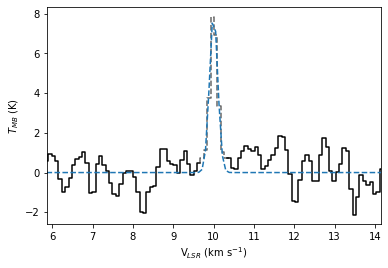

In [6]:
x1 = 89
y1 = 110

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
make_plot_with_masked_chans(ax, x1, y1)
plot_available_gaussians(ax, x1, y1, 1)

Now, lets try that same plot in a region where is a fit with both masked and not masked data (for 1Gauss)

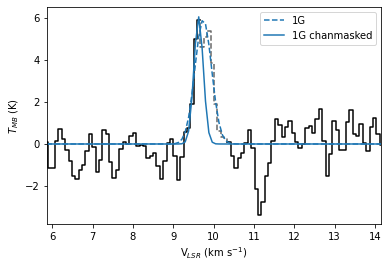

In [7]:
x2 = 109
y2 = 144

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
make_plot_with_masked_chans(ax, x2, y2)
plot_available_gaussians(ax, x2, y2, 1)
ax.legend()

Now we plot a spectrum that has 2 gaussian fits in both masked and not masked data

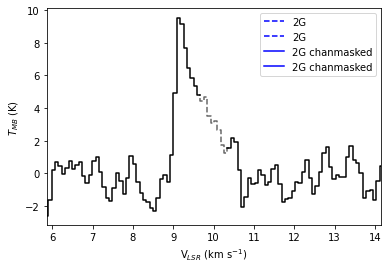

In [8]:
x3 = 125
y3 = 129

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
make_plot_with_masked_chans(ax, x3, y3)
# plot_available_gaussians(ax, x3, y3, 1)
plot_available_gaussians(ax, x3, y3, 2, gausscolor='blue')
# plot_gaussian_sum(ax, x3, y3, 2, gausscolor='red')
ax.legend()

Lets look at a case where there could be 3 gaussians 

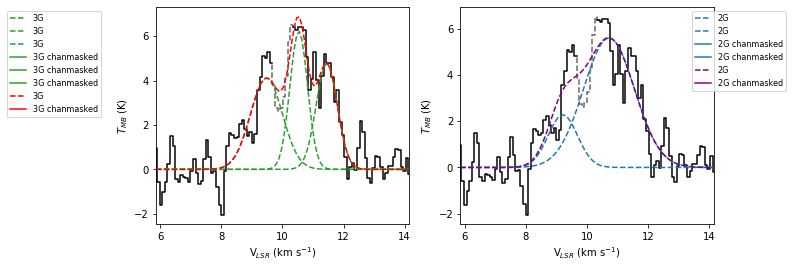

In [9]:
x4 = 136
y4 = 129

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
make_plot_with_masked_chans(ax, x4, y4)
plot_available_gaussians(ax, x4, y4, 3, gausscolor='C2')
plot_gaussian_sum(ax, x4, y4, 3, gausscolor='red')
ax.legend(fontsize=8, bbox_to_anchor=(-0.2, 1))

ax2 = fig.add_subplot(122)
make_plot_with_masked_chans(ax2, x4, y4)
plot_available_gaussians(ax2, x4, y4, 2, gausscolor='C0')
plot_gaussian_sum(ax2, x4, y4, 2, gausscolor='purple')
ax2.legend(fontsize=8, bbox_to_anchor=(1.3, 1))

In the previous case, there was no available 3G fit for the map with filtered channels. Lets look at a spectra which has a 3G fit in the masked case

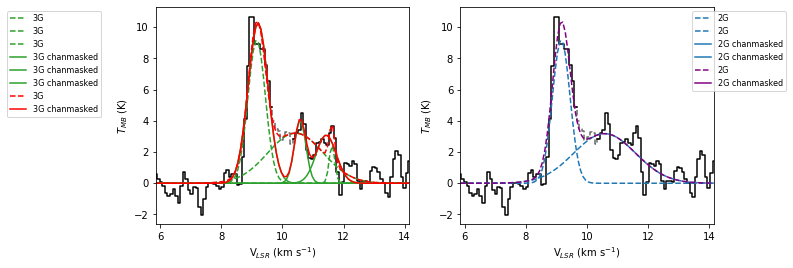

In [10]:
x5 = 143
y5 = 140

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
make_plot_with_masked_chans(ax, x5, y5)
plot_available_gaussians(ax, x5, y5, 3, gausscolor='C2')
plot_gaussian_sum(ax, x5, y5, 3, gausscolor='red')
ax.legend(fontsize=8, bbox_to_anchor=(-0.2, 1))

ax2 = fig.add_subplot(122)
make_plot_with_masked_chans(ax2, x5, y5)
plot_available_gaussians(ax2, x5, y5, 2, gausscolor='C0')
plot_gaussian_sum(ax2, x5, y5, 2, gausscolor='purple')
ax2.legend(fontsize=8, bbox_to_anchor=(1.3, 1))

It might be worth it to see what happens when we leave the 3G and then evalua

## Plot of the parameter results in image space

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered co

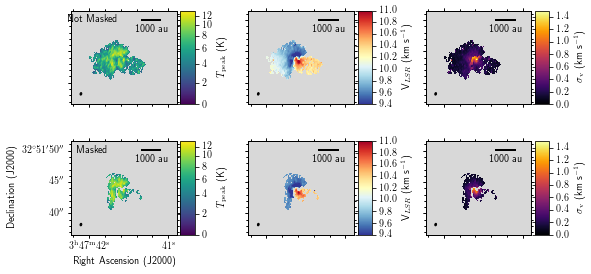

In [14]:
# plot all parameters of the 1G in the same figure comparing the masked and non-masked
savefigure = True
fig = plt.figure(figsize=(8,4))
figname = 'B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_allparams_1G.pdf'

fitcube = fits.getdata(fitfile1G)

fitcube_chanmasked = fits.getdata(fitfile1G_chanmasked)

paramscube = np.concatenate([fitcube[:3], fitcube_chanmasked[:3]])
headerplot = fits.getheader(mask2dfile)
Tmax = np.max([np.round(np.nanmax(paramscube[0]), 1), np.round(np.nanmax(paramscube[3]), 1)])
sigmamax = np.max([np.round(np.nanmax(paramscube[2]), 1), np.round(np.nanmax(paramscube[5]), 1)])
stretch = ['arcsinh','linear','linear','arcsinh','linear','linear']
vmin = [0, 10.2-0.8, 0, 0, 10.2-0.8, 0]
vmax = [Tmax, 10.2+0.8, sigmamax, Tmax, 10.2+0.8, sigmamax]
cmap = ['viridis', 'RdYlBu_r', 'inferno', 'viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)', r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (2,3,i+1), stretch[i], \
                            vmin[i], vmax[i], cmap[i], label_col='k',barsize=1000, vmid=5)
    ax0.colorbar.set_axis_label_text(quantities[i])
    if i%3 == 0:
        if i%6 == 0:
            ax0.add_label(0.2, 0.9, 'Not Masked', relative=True)
        else:
            ax0.add_label(0.21, 0.9,'Masked', relative=True)
    if i!=3:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()

        
fig.tight_layout(pad=0)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered co

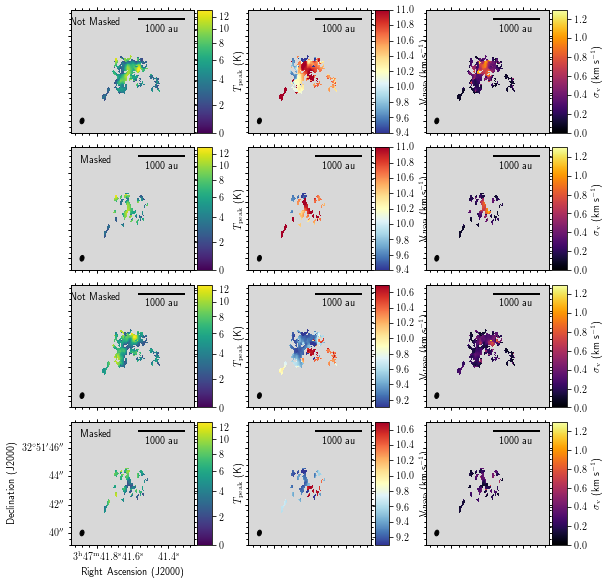

In [12]:
# plot all parameters of the 2G in the same figure comparing the masked and non-masked
savefigure = True
fig = plt.figure(figsize=(8,8))
figname = 'B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_allparams_2G.pdf'

fitcube = fits.getdata(fitfile2G)

fitcube_chanmasked = fits.getdata(fitfile2G_chanmasked)

#normal component 1, masked component1, normal compoent 2, masked component 2
paramscube = np.concatenate([fitcube[:3], fitcube_chanmasked[:3], fitcube[3:6], fitcube_chanmasked[3:6]])
headerplot = fits.getheader(mask2dfile)
Tmax1 = np.max([np.round(np.nanmax(paramscube[0]), 1), np.round(np.nanmax(paramscube[3]), 1)])
sigmamax1 = np.max([np.round(np.nanmax(paramscube[2]), 1), np.round(np.nanmax(paramscube[5]), 1)])
Tmax2 = np.max([np.round(np.nanmax(paramscube[6]), 1), np.round(np.nanmax(paramscube[9]), 1)])
sigmamax2 = np.max([np.round(np.nanmax(paramscube[8]), 1), np.round(np.nanmax(paramscube[11]), 1)])
stretch = ['arcsinh','linear','linear','arcsinh','linear','linear', 'arcsinh','linear','linear','arcsinh','linear','linear']
vmin = [0, 10.2-0.8, 0, 0, 10.2-0.8, 0, 0, 9.9-0.8, 0, 0, 9.9-0.8, 0]
vmax = [Tmax1, 10.2+0.8, sigmamax1, Tmax1, 10.2+0.8, sigmamax1, Tmax2, 9.9+0.8, sigmamax2, Tmax2, 9.9+0.8, sigmamax2]
cmap = ['viridis', 'RdYlBu_r', 'inferno', 'viridis', 'RdYlBu_r', 'inferno', 'viridis', 'RdYlBu_r', 'inferno', 'viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)', 
              r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)', 
              r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)', 
              r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (4,3,i+1), stretch[i], \
                            vmin[i], vmax[i], cmap[i], label_col='k',barsize=1000, vmid=5)
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(ra_yso, dec_yso, 0.0012)
    ax0.tick_labels.set_xformat('hh:mm:ss.s')
    if i%3 == 0:
        if i%6 == 0:
            ax0.add_label(0.2, 0.9, 'Not Masked', relative=True)
        else:
            ax0.add_label(0.21, 0.9,'Masked', relative=True)
    if i!=9:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()

        
fig.tight_layout(pad=0)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered co

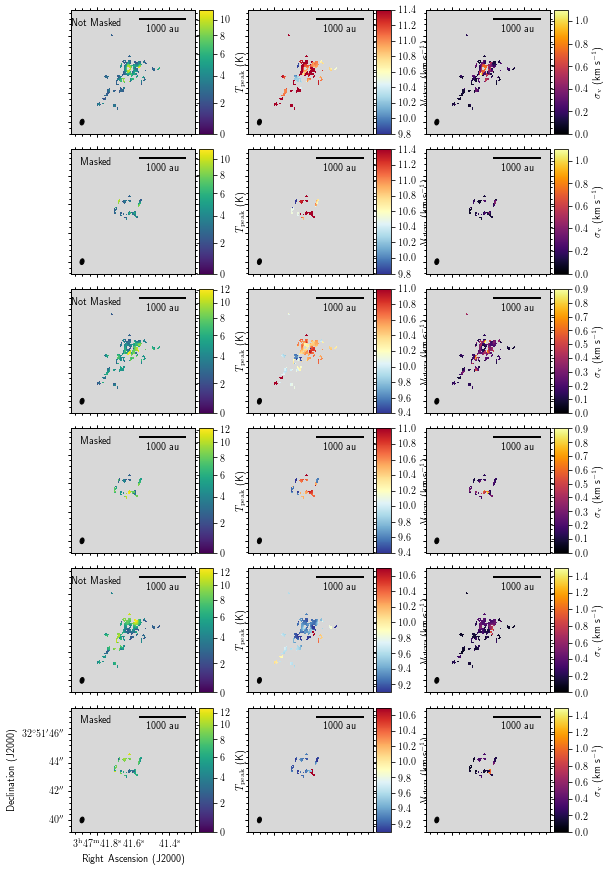

In [13]:
# plot all parameters of the 3G in the same figure comparing the masked and non-masked
savefigure = True
fig = plt.figure(figsize=(8,12))
figname = 'B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_allparams_3G.pdf'

fitcube = fits.getdata(fitfile3G)

fitcube_chanmasked = fits.getdata(fitfile3G_chanmasked)

#normal component 1, masked component1, normal compoent 2, masked component 2, normal component 3, masked compoonent 3
paramscube = np.concatenate([fitcube[:3], fitcube_chanmasked[:3], fitcube[3:6], fitcube_chanmasked[3:6], fitcube[6:9], fitcube_chanmasked[6:9]])
headerplot = fits.getheader(mask2dfile)
Tmax1 = np.max([np.round(np.nanmax(paramscube[0]), 1), np.round(np.nanmax(paramscube[3]), 1)])
sigmamax1 = np.max([np.round(np.nanmax(paramscube[2]), 1), np.round(np.nanmax(paramscube[5]), 1)])
Tmax2 = np.max([np.round(np.nanmax(paramscube[6]), 1), np.round(np.nanmax(paramscube[9]), 1)])
sigmamax2 = np.max([np.round(np.nanmax(paramscube[8]), 1), np.round(np.nanmax(paramscube[11]), 1)])
Tmax3 = np.max([np.round(np.nanmax(paramscube[12]), 1), np.round(np.nanmax(paramscube[15]), 1)])
sigmamax3 = np.max([np.round(np.nanmax(paramscube[14]), 1), np.round(np.nanmax(paramscube[17]), 1)])

stretch = ['arcsinh','linear','linear','arcsinh','linear','linear', 
           'arcsinh','linear','linear','arcsinh','linear','linear',
           'arcsinh','linear','linear','arcsinh','linear','linear']
vmin = [0, 10.6-0.8, 0, 0, 10.6-0.8, 0, 
        0, 10.2-0.8, 0, 0, 10.2-0.8, 0, 
        0, 9.9-0.8, 0, 0, 9.9-0.8, 0]
vmax = [Tmax1, 10.6+0.8, sigmamax1, Tmax1, 10.6+0.8, sigmamax1, 
        Tmax2, 10.2+0.8, sigmamax2, Tmax2, 10.2+0.8, sigmamax2, 
        Tmax3, 9.9+0.8, sigmamax3, Tmax3, 9.9+0.8, sigmamax3]
cmap = ['viridis', 'RdYlBu_r', 'inferno', 'viridis', 'RdYlBu_r', 'inferno', 
        'viridis', 'RdYlBu_r', 'inferno', 'viridis', 'RdYlBu_r', 'inferno', 
        'viridis', 'RdYlBu_r', 'inferno', 'viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)', 
              r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)', 
              r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)', 
              r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)',
              r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)', 
              r'$T_{\mathrm{peak}}$ (K)', r'V$_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (6,3,i+1), stretch[i], \
                            vmin[i], vmax[i], cmap[i], label_col='k',barsize=1000, vmid=5)
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(ra_yso, dec_yso, 0.0012)
    ax0.tick_labels.set_xformat('hh:mm:ss.s')
    if i%3 == 0:
        if i%6 == 0:
            ax0.add_label(0.2, 0.9, 'Not Masked', relative=True)
        else:
            ax0.add_label(0.21, 0.9,'Masked', relative=True)
    if i!=15:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()

        
fig.tight_layout(pad=0)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')